# Rational Exponent as Speed Bottleneck in Dynamic Asset Problems

Rational exponentiation is perhaps one of the core computational tasks in solving any dynamic models. 

It turns out, in solving a model with CRRA utility for example, the vast majority of computing time might be spent on the single task of exponentiating to a rational number.

When the exponentiation is integer based, things are quicker. Whether integer or not, exponents are dramatically more time consuming to compute than addition subtraction etc. 

For fully grid based solution algorithm, since maximization is almost instantaneous, the computing burden falls disproportionately on the exponentiation of potentially very large gridded matrixes. 

If one could compute $x^\rho$ y percent faster, that almost leads to y percent (linear) improvements in overall computing time. 

So how do we improve exponentiation time?

Well, regardless of the number of choices you have, consumption at the end, in the standard problem, enters under the rational exponent by itself. So we have a one dimensional problem. 

Imagine that we are to evaluate a 1 million (endo states) by 15 (exo shocks) matrix of consumption values, how do we make this go faster?

There is a wide variety of ways potentially. The method explored here is through 1d interpolation, which is can be extremely accurate given that we know the analytical solution to $x^\rho$. This is a trivial interpolation problem compared to interpolating over Value or Policy functions given high dimensional state space. 

In fact, we face a potential interpolation tradeoff:

1. we could solve a problem with a small set of grid points and interpolate over the value function approximations, this has low memory burden but relies more on approximation.
2. we could alternatively use very dense grids and interpolate within period utility function, this has high memory burden but is potentially more accurate.

Both paths could be equally fast. 

Here, this problem and interpolation solution is demonstrated in the context of Matlab relevant for the second route. 

## The Problem

In [1]:
clear all;
st_single_double = 'double';
z = 15;
iter = 50;

it_rown = 200; % 4GB if 1000
it_coln = round(((it_rown-1)*it_rown)/2 + it_rown);

c_min = 0.01;
c_max = 60;
tic;
mt_c = rand([it_rown*it_coln,1])*(c_max - c_min) + c_min;
mt_c = sort(mt_c);

if (strcmp(st_single_double, 'single'))
    mt_c = single(mt_c);
end
toc;

Elapsed time is 0.160515 seconds.



In [2]:
whos

  Name                        Size               Bytes  Class     Attributes

  c_max                       1x1                    8  double              
  c_min                       1x1                    8  double              
  it_coln                     1x1                    8  double              
  it_rown                     1x1                    8  double              
  iter                        1x1                    8  double              
  mt_c                  4020000x1             32160000  double              
  st_single_double            1x6                   12  char                
  z                           1x1                    8  double              




In [3]:
% Define Function Handle
fl_crra = 1.5;
if (strcmp(st_single_double, 'single'))
    fl_crra = single(fl_crra);
end
fu_c = @(c) (((c).^(1-fl_crra)-1)./(1-fl_crra));
fu_c_fixed = @() fu_c(mt_c);

In [4]:
% Compute Time Cost
fl_t_direct_eval = timeit(fu_c_fixed);
disp(fl_t_direct_eval)
disp(fl_t_direct_eval*z*iter)

    0.0813

   60.9695




## Pre-Compute and Interpolate

Suppose we are interested in $c^\rho$, where $\rho$ is possibly a fraction.

In [5]:
% C array
fl_mt_c_min = min(mt_c, [], 'all');
fl_mt_c_max = max(mt_c, [], 'all');
it_max_n = (fl_mt_c_max-fl_mt_c_min)/(10^-3);
it_interp_points = min(it_rown*it_coln, it_max_n)


it_interp_points =

   5.9990e+04




In [6]:
ar_fl_c_grid = linspace(fl_mt_c_min, fl_mt_c_max, min(it_rown*it_coln, it_max_n));
if (strcmp(st_single_double, 'single'))
    ar_fl_c_grid = single(ar_fl_c_grid);
end
fl_ar_c_grid_gap = ar_fl_c_grid(2) - ar_fl_c_grid(1);
disp(length(ar_fl_c_grid))
disp(ar_fl_c_grid(2) - ar_fl_c_grid(1))

       59989

    0.0010




### Interpolate Method 1--interp1d

In [7]:
% Evaluate
ar_fl_u_at_c_grid = fu_c(ar_fl_c_grid);
% Interpolation Evaluator
fu_interp_near_c_fixed = @() interp1(ar_fl_c_grid, ar_fl_u_at_c_grid, mt_c, 'nearest');
fu_interp_linr_c_fixed = @() interp1(ar_fl_c_grid, ar_fl_u_at_c_grid, mt_c, 'linear');

In [8]:
% Compute Time Cost
fl_time_interp_near = timeit(fu_interp_near_c_fixed);
disp(fl_time_interp_near)
disp(fl_time_interp_near*z*iter)

    0.0133

    9.9682




In [9]:
fl_time_interp_linr = timeit(fu_interp_linr_c_fixed);
disp(fl_time_interp_linr)
disp(fl_time_interp_linr*z*iter)

    0.0132

    9.9233




### Interpolate Method 2--Index based Interpolation

In [10]:
% Get Quotient
fix((mt_c-min(mt_c, [], 'all'))./fl_ar_c_grid_gap) + 1;
fl_mt_c_min = min(mt_c, [], 'all');

In [11]:
fu_interp_near_c_idx_fixed = @() ar_fl_u_at_c_grid(fix((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1);
fu_interp_near_c_rnd_fixed = @() ar_fl_u_at_c_grid(round((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1);

In [12]:
% Compute Time Cost
fl_time_interp_near_idx = timeit(fu_interp_near_c_idx_fixed);
disp(fl_time_interp_near_idx)
disp(fl_time_interp_near_idx*z*iter)

    0.0506

   37.9640




In [13]:
% Compute Time Cost
fl_time_interp_near_rnd = timeit(fu_interp_near_c_rnd_fixed);
disp(fl_time_interp_near_rnd)
disp(fl_time_interp_near_rnd*z*iter)

    0.0551

   41.3082




### Interpolate Method 3--griddedInterpolant (introduced since matlab R2011b)

In [14]:
% Generate Interpolant
ar_fl_u_at_c_grid = fu_c(ar_fl_c_grid);
f_grid_interpolant_near = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid, 'nearest')
f_grid_interpolant_linr = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid, 'linear')
f_grid_interpolant_spln = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid, 'spline')

% Interpolation Evaluator
fu_interp_gridded_near = @() f_grid_interpolant_near(mt_c);
fu_interp_gridded_linr = @() f_grid_interpolant_linr(mt_c);
fu_interp_gridded_spln = @() f_grid_interpolant_spln(mt_c);


f_grid_interpolant_near = 

  griddedInterpolant with properties:

            GridVectors: {[1x59989 double]}
                 Values: [1x59989 double]
                 Method: 'nearest'
    ExtrapolationMethod: 'nearest'


f_grid_interpolant_linr = 

  griddedInterpolant with properties:

            GridVectors: {[1x59989 double]}
                 Values: [1x59989 double]
                 Method: 'linear'
    ExtrapolationMethod: 'linear'


f_grid_interpolant_spln = 

  griddedInterpolant with properties:

            GridVectors: {[1x59989 double]}
                 Values: [1x59989 double]
                 Method: 'spline'
    ExtrapolationMethod: 'spline'




In [15]:
% Compute Time Cost
fl_time_gridded_near = timeit(fu_interp_gridded_near);
disp(fl_time_gridded_near)
disp(fl_time_gridded_near*z*iter)

    0.0089

    6.6945




In [16]:
% Compute Time Cost
fl_time_gridded_linr = timeit(fu_interp_gridded_linr);
disp(fl_time_gridded_linr)
disp(fl_time_gridded_linr*z*iter)

    0.0091

    6.7889




In [17]:
% Compute Time Cost
fl_time_gridded_spln = timeit(fu_interp_gridded_spln);
disp(fl_time_gridded_spln)
disp(fl_time_gridded_spln*z*iter)

    0.0091

    6.8264




#### griddedInterpolant graphing

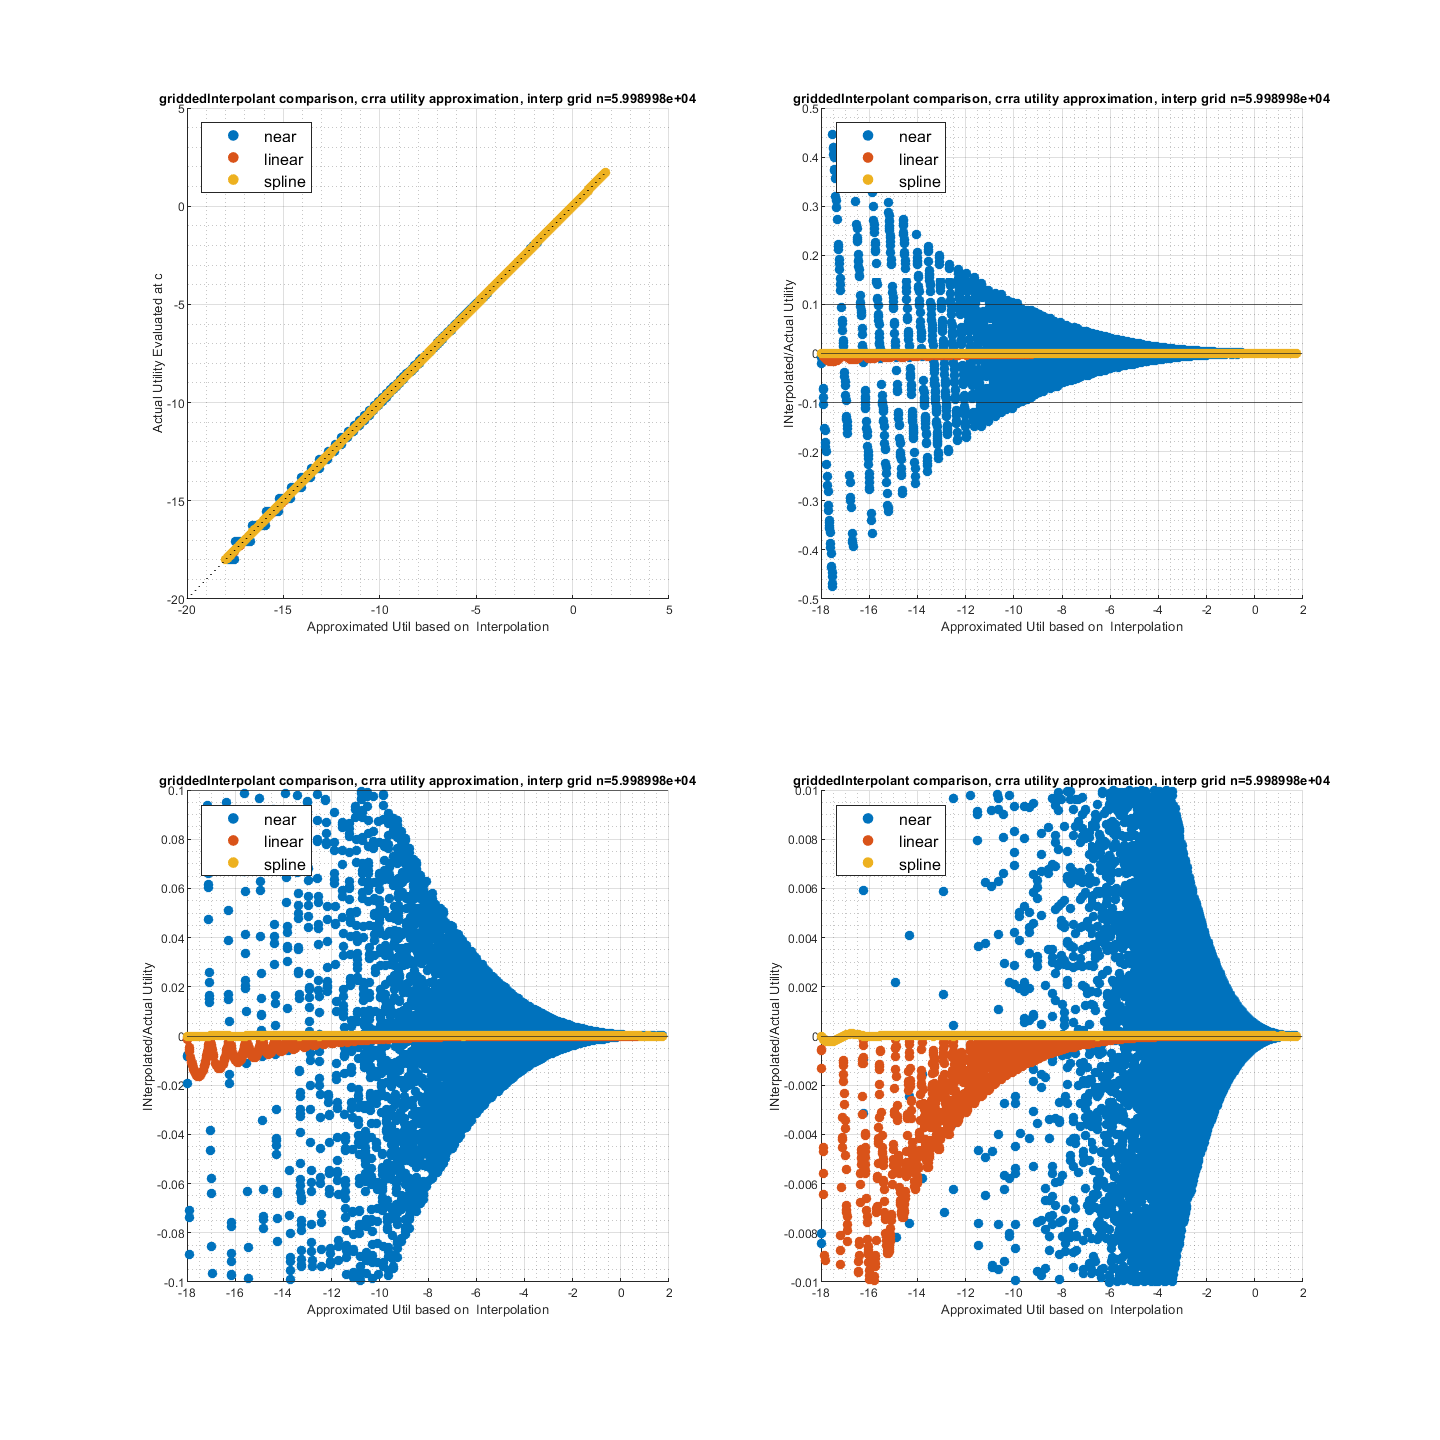

In [18]:
fl_fu_c_fixed = fu_c_fixed();
ar_interp_gridded_near = fu_interp_gridded_near();
ar_interp_gridded_linr = fu_interp_gridded_linr();
ar_interp_gridded_spln = fu_interp_gridded_spln();

figure('PaperPosition', [0 0 15 15]);

for sub_j=1:1:4    
    subplot(2,2,sub_j)
    hold on;
        
    if (sub_j == 1) 
        ar_divide_by = 0;
    else
        ar_divide_by = fl_fu_c_fixed(:);
    end
    
    g1 = scatter(fl_fu_c_fixed(:),  ar_interp_gridded_near(:)-ar_divide_by, 30, 'filled');
    g2 = scatter(fl_fu_c_fixed(:),  ar_interp_gridded_linr(:)-ar_divide_by, 30, 'filled');
    g3 = scatter(fl_fu_c_fixed(:),  ar_interp_gridded_spln(:)-ar_divide_by, 30, 'filled');
    legend([g1, g2, g3], {'near','linear','spline'}, 'Location','northwest',...
            'NumColumns',1,'FontSize',12,'TextColor','black');        
            
    if (sub_j == 1)             
        hline = refline([1 0]);
        hline.Color = 'k';
        hline.LineStyle = ':';
        hline.HandleVisibility = 'off';
        ylabel('Actual Utility Evaluated at c')
    else
        yline0 = yline(0);
        yline0.HandleVisibility = 'off';
        yline1 = yline(0.1);
        yline1.HandleVisibility = 'off';
        yline2 = yline(-0.1);
        yline2.HandleVisibility = 'off';
        ylabel('INterpolated/Actual Utility')
        
        if (sub_j == 3) 
            ylim([-0.1, 0.1])
        end
        if (sub_j == 4) 
            ylim([-0.01, 0.01])
        end        
    end
    
    grid on;
    grid minor;

    title(sprintf('griddedInterpolant comparison, crra utility approximation, interp grid n=%d', it_interp_points))
    
    xlabel('Approximated Util based on  Interpolation')
end